In [110]:
from IPython.display import Image
import warnings
from setups import *
from plotting import *
warnings.filterwarnings("ignore")
%matplotlib inline
# Where to save the figures
PROJECT_ROOT_DIR = "."

# Prepare data

In [118]:
data_root = tf.keras.utils.get_file(
  'flower_photos','http://download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [114]:
# Resize all of them to 150x150
IMAGE_SHAPE = (150, 150)
#Split images to 75-25% for training and test
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,validation_split=0.25)
train_generator = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, batch_size=20, subset="training")
valid_generator= image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE, batch_size=20, subset="validation")

Found 2755 images belonging to 5 classes.
Found 915 images belonging to 5 classes.


In [115]:
for image_batch, label_batch in train_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (20, 150, 150, 3)
Label batch shape:  (20, 5)


In [116]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20, 5)


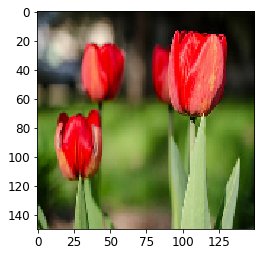

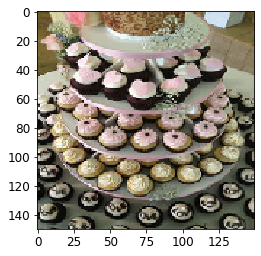

In [117]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image
i = 0
for batch in train_generator:
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0][0]))
    i += 1
    if i % 2 == 0:
        break

# Use VGG16 model

In [87]:
from keras import applications

# Use a VGG16 pre-trained model,& remove the top layers
image_w, image_h = 150, 150
model = applications.VGG16(weights = "imagenet", include_top=False, input_shape = (image_w, image_h, 3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [88]:
type(model)

keras.engine.training.Model

In [89]:
# Adding custom layers to create a new model 
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import optimizers

new_model = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')
])
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


# Model 1:  freeze all layers of VGG16, train (fine-tune) and evaluate the model

# Please note that due to limited computation power of my PC, I will set epoch=2 for all models in this assignment

In [119]:
# Freezing the layers 
for layer in model.layers[0:19]:
    layer.trainable = False
# Trainable layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [120]:
new_model_1 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')])
new_model_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 2,098,693
Non-trainable params: 14,714,688
_________________________________________________________________


In [92]:
new_model_1.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])

In [96]:
new_model_1_result = new_model_1.fit_generator(train_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 437s 3s/step - loss: 1.3963 - acc: 0.4375
Epoch 2/2
137/137 [==============================] - 460s 3s/step - loss: 1.1044 - acc: 0.6279


In [97]:
new_model_1_val_result = new_model_1.fit_generator(valid_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 421s 3s/step - loss: 1.0300 - acc: 0.6319
Epoch 2/2
137/137 [==============================] - 422s 3s/step - loss: 0.9012 - acc: 0.6887


# Model 2:unfreeze the last block of VGG16 (block5), re-train and evaluate the model

In [98]:
# Freezing the layers 
for layer in model.layers[15:19]:
    layer.trainable = True
# Trainable layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [99]:
new_model_2 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')])
new_model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 9,178,117
Non-trainable params: 7,635,264
_________________________________________________________________


In [100]:
new_model_2.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])

In [101]:
new_model_2_result = new_model_2.fit_generator(train_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 478s 3s/step - loss: 1.2125 - acc: 0.5299
Epoch 2/2
137/137 [==============================] - 474s 3s/step - loss: 0.7123 - acc: 0.7440


In [102]:
new_model_2_val_result = new_model_2.fit_generator(valid_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 474s 3s/step - loss: 0.5135 - acc: 0.8223
Epoch 2/2
137/137 [==============================] - 474s 3s/step - loss: 0.3102 - acc: 0.9112


# Model 3:Unfreeze all the layers and try again

In [103]:
for layer in model.layers[:19]:
    layer.trainable = True
# Trainable layers
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_4 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [104]:
new_model_3 = Sequential([
    model,
    Flatten(name='flatten'),
    Dense(256, activation='relu', name='new_fc1'),
    Dense(5, activation='softmax', name='new_predictions')])
new_model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
new_fc1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
new_predictions (Dense)      (None, 5)                 1285      
Total params: 16,813,381
Trainable params: 16,813,381
Non-trainable params: 0
_________________________________________________________________


In [105]:
new_model_3.compile(loss = "categorical_crossentropy", 
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])

In [106]:
new_model_3_result = new_model_3.fit_generator(train_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 1045s 8s/step - loss: 0.7980 - acc: 0.6948
Epoch 2/2
137/137 [==============================] - 1044s 8s/step - loss: 0.4125 - acc: 0.8515


In [107]:
new_model_3_val_result = new_model_3.fit_generator(valid_generator, epochs=2, steps_per_epoch=int(0.75 * 3670 / 20), validation_steps=int(0.25 * 3670 / 20)) 

Epoch 1/2
137/137 [==============================] - 1038s 8s/step - loss: 0.3502 - acc: 0.8820
Epoch 2/2
137/137 [==============================] - 1033s 8s/step - loss: 0.1302 - acc: 0.9616


# Compare the accuracy you got in both cases . Which one is better and why?

In [ ]:
#Based on results shown above, Model 3 can be the best as it has highest accuracy ratio based on both traning and test sets.